In [1]:
import sys
sys.path.insert(0, '/home/jianx/search-exposure/')
from network import DSSM
from train import train
from load_data import load
from gpu_allocator import select_device
from gpu_allocator import cleanup_gpu_list
import torch
import csv
from test import test
from test import test_loader
from test import get_ndcg_precision_rr
import random
from train import generate_sparse

In [2]:
num_epochs = 2
epoch_size = 100
batch_size = 100
learning_rate = 0.1
embed_size = 128

print("Num of epochs:", num_epochs)
print("Epoch size:", epoch_size)
print("Batch size:", batch_size)
print("Learning rate:", learning_rate)
print("Embedding size:", embed_size)
rank = 10
test_batch =43
MODEL_PATH = "/home/jianx/data/results/"

Num of epochs: 2
Epoch size: 100
Batch size: 100
Learning rate: 0.1
Embedding size: 128


In [3]:
print("Loading data")
pos_neg_dict, query_dict, passage_dict, top_dict, rating_dict, query_test_dict = load()
print("Data successfully loaded.")
print("Positive Negative Pair dict size: " + str(len(pos_neg_dict)))
print("Num of queries: " + str(len(query_dict)))
print("Num of passages: " + str(len(passage_dict)))

Loading data
Data successfully loaded.
Positive Negative Pair dict size: 400782
Num of queries: 808731
Num of passages: 8841823


In [56]:
CURRENT_DEVICE = torch.device("cuda:0")
net = torch.load("/home/jianx/data/results/300_1500_100_0.01_128.model").to(CURRENT_DEVICE)

In [57]:
result_dict = test_loader(net, CURRENT_DEVICE, test_batch, top_dict, query_test_dict, passage_dict, rating_dict)
qids = list(result_dict.keys())

[(670481, 0.9999756217002869), (4566824, 0.9999663829803467), (1410041, 0.9999235272407532), (2068920, 0.9998124837875366), (1772932, 0.9998089671134949), (6013434, 0.9997748732566833), (6269138, 0.9996452927589417), (2047317, 0.9994300603866577), (2177457, 0.9994229078292847), (375160, 0.9993213415145874), (3485338, 0.9991768002510071), (2708866, 0.9991405606269836), (3420648, 0.9988572001457214), (2189958, 0.9986824989318848), (1362493, 0.9986491203308105), (3597102, 0.9986398816108704), (2278341, 0.9986169338226318), (1772930, 0.9983949661254883), (2755128, 0.9982117414474487), (5661706, 0.9979556202888489), (5931271, 0.997827410697937), (8103066, 0.9975945949554443), (5356040, 0.9969929456710815), (4839324, 0.9969137907028198), (275728, 0.9965823888778687), (5931270, 0.9964625835418701), (813465, 0.9963494539260864), (5688163, 0.9956538677215576), (4566820, 0.9951678514480591), (812331, 0.9951290488243103), (9981, 0.9948809742927551), (7176430, 0.9947977066040039), (5957960, 0.9945

In [58]:
with open('/home/jianx/data/trec_eval/300_1500_100_0.01_128.teIn', 'w+') as f:
    for qid in qids:
        for rank, item in enumerate(sorted(result_dict[qid].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True)):
            f.write("{}\tQ0\t{}\t{}\t{}\trun-id\n".format(qid, item[0],rank+1, item[1]))

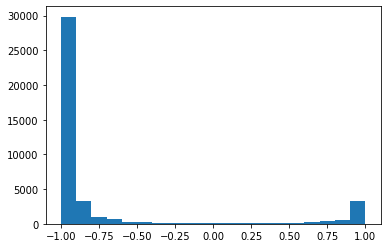

0.06888065883728862
0.6879294381365431


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
all_scores = []
num_95 = 0
num_neg95 = 0
for i in qids:
    for item in sorted(result_dict[i].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True):
        all_scores.append(item[1])
        if item[1] > 0.95:
            num_95+=1
        if item[1] < -0.95:
            num_neg95 += 1
plt.hist(all_scores, bins=20)
plt.show()
print(num_95/len(all_scores))
print(num_neg95/len(all_scores))

In [51]:
top_pids = []
qid = 1
for i in range(10):
    top_pids.append(sorted(result_dict[qids[qid]].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True)[i][0])
print(top_pids)

[5978021, 5288186, 2211418, 4370203, 8031509, 6010960, 684093, 684084, 6773977, 5568229]


(array([763.,  32.,  22.,   9.,  10.,   5.,  15.,  13.,  20., 111.]),
 array([-9.99860346e-01, -7.99874693e-01, -5.99889040e-01, -3.99903387e-01,
        -1.99917734e-01,  6.79194927e-05,  2.00053573e-01,  4.00039226e-01,
         6.00024879e-01,  8.00010532e-01,  9.99996185e-01]),
 <a list of 10 Patch objects>)

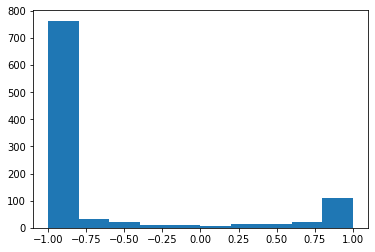

In [52]:
result0 = pd.DataFrame.from_dict(sorted(result_dict[qids[11]].items(), key=lambda x: (x[1], [-1, 1][random.randrange(2)]), reverse=True))
plt.hist(result0[1])

In [55]:
import math
def get_ndcg_precision_rr(true_dict, test_dict, rank):
    sorted_result = sorted(test_dict.items(), key=lambda x: (x[1], [-1,1][random.randrange(2)]), reverse=True)
    original_rank = rank
    rank = min(rank, len(sorted_result))
    cumulative_gain = 0
    ideal_dict = {}
    num_positive = 0
    rr = float("NaN")
    for i in range(len(sorted_result)):
        pid = sorted_result[i][0]
        if pid in true_dict:
            rr = 1 / (i + 1)
            break
    for i in range(rank):
        pid = sorted_result[i][0]
        if pid in true_dict:
            num_positive += 1
    sorted_result = sorted(test_dict.items(), key=lambda x: x[1], reverse=True)
    for i in range(rank):
        pid = sorted_result[i][0]
        relevance = 0
        if pid in true_dict:
            relevance = true_dict[pid]
        ideal_dict[pid] = relevance
        discounted_gain = relevance / math.log2(2 + i)
        cumulative_gain += discounted_gain
    sorted_ideal = sorted(ideal_dict.items(), key=lambda x: x[1], reverse=True)
    ideal_gain = 0
    for i in range(rank):
        relevance = sorted_ideal[i][1]
        discounted_gain = relevance / math.log2(2 + i)
        ideal_gain += discounted_gain
    ndcg = 0
    if ideal_gain != 0:
         ndcg = cumulative_gain / ideal_gain
    return ndcg, num_positive / original_rank, rr
import numpy as np
result_ndcg = []
result_prec = []
result_rr = []
for qid in qids:
    if len(result_dict[qid]) < 10:
        print(qid)
    ndcg, prec, rr = get_ndcg_precision_rr(rating_dict[qid], result_dict[qid], 10)
    result_ndcg.append(ndcg)
    result_prec.append(prec)
    result_rr.append(rr)
print(result_ndcg)
avg_ndcg = np.nanmean(result_ndcg)
avg_prec = np.nanmean(result_prec)
avg_rr = np.nanmean(result_rr)
print(avg_ndcg,avg_prec,avg_rr)

855410
[0.0, 0.0, 0.039199134489337664, 0.06254806489603015, 0.31272240519294714, 0.0, 0.39251161196483586, 0.02613275632622511, 0.22144914072598187, 0.0, 0.0, 0.0, 0.0, 0.38459377241376086, 0.0, 0.0, 0.44489713827693894, 0.04416948230292602, 0.3602664366984503, 0.09478836436955078, 0.0, 0.0, 0.0, 0.0357836213106698, 0.0, 0.02120692939965057, 0.0, 0.04956816867644055, 0.15633336444022494, 0.0, 0.0, 0.1610425878239398, 0.11004588314904007, 0.0, 0.02619491033944881, 0.7746469457232199, 0.0, 0.3824599464381624, 0.0, 0.2934556883974402, 0.2996484034259831, 0.0, 0.0]
0.10915499434374895 0.11395348837209301 0.2986359407197313


In [30]:
test_qid = 1133167
test_pid = 6112590
test_q_embed = net(generate_sparse(query_test_dict[test_qid]).to(CURRENT_DEVICE)).detach()
test_p_embed = net(generate_sparse(passage_dict[test_pid]).to(CURRENT_DEVICE)).detach()
test_score = torch.cosine_similarity(test_q_embed.unsqueeze(0), test_p_embed.unsqueeze(0)).item()
print(test_score)
print(test_p_embed)

print(test_q_embed)

-0.8975946307182312
tensor([-3.0296e+03, -5.2848e+04,  2.3425e-02,  6.3025e-02, -1.0471e-01,
        -1.2495e+03,  2.3125e+04,  6.2536e-02,  1.3906e-01,  2.3375e+04,
        -2.5828e+04,  4.8552e+02, -4.4572e+03, -2.1202e+04, -2.2999e-02,
         9.1718e-02, -4.9721e+04, -4.0220e+03,  3.5009e-01, -2.2760e+04,
        -1.8646e+04,  1.6650e+03, -4.0550e+04, -2.2024e+04,  5.0473e+04,
        -4.8476e+04,  1.4154e+04, -1.0826e+03, -6.3183e+03,  1.4134e-01,
        -8.9433e+03,  3.2223e+04, -9.0528e+03,  5.4107e+04,  4.3253e+04,
        -1.0032e+04, -9.7527e+03, -4.7771e+04,  2.5884e+04, -7.8262e+03,
         2.0455e-01,  5.1378e+04,  9.3307e+03,  6.5136e+03,  1.5810e+04,
         1.3519e-02, -1.0916e+04, -9.4892e+02,  4.7940e+03,  8.1336e+03,
        -3.5506e+04,  5.5301e+04, -2.1024e+04, -7.8287e+03,  2.0133e+04,
         5.7350e+03,  4.4025e+04,  2.8542e-02,  2.8935e+04,  2.3223e+04,
        -4.4460e+04, -1.4056e+04,  4.0348e+04,  8.1690e+03, -2.3161e-02,
         9.8422e+03,  7.1057e+0